In [28]:
import torch
import torchvision
from torch.utils.data import DataLoader
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
import time
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Lambda
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# loading all packages here to start
from eval_patch_features.logistic import eval_linear
from eval_patch_features.ann import eval_ANN
from eval_patch_features.knn import eval_knn
from eval_patch_features.protonet import eval_protonet
from eval_patch_features.metrics import get_eval_metrics, print_metrics
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Configurations

In [29]:
# configs
VECTOR_DIM = 512  # size of input feature vector
HIDDEN_DIM = 768   # size of ANN hidden layer
BATCH_SIZE = 8
K_FOLDS_PATH = r"E:\Aamir Gulzar\dataset\splits\kfolds.csv"
DATA_PATH = r"E:\Aamir Gulzar\dataset\baseline_features"
MODEL_SAVE_PATH = r"E:\Aamir Gulzar\WSI_Classification_Using_FM_Features\test\baseline_Average_Classifiers"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
# torch.tensor([1.2, 3.4]).device

In [30]:
# data = r"E:\Aamir Gulzar\dataset\CAIMAN_Fivecrop_NormFeatures"
# data_save = r"E:\Aamir Gulzar\dataset\CAIMAN_Features"

# # load the data
# for wsi in os.listdir(data):
#     wsi_data = []
#     for patch in os.listdir(j_(data, wsi)):
#         patch_data = torch.load(j_(data, wsi, patch))
#         # check if the loaded feature vector is five crop then average it first then append to the wsi_data
#         if patch_data.shape[0] > 1:
#             patch_data = patch_data.mean(dim=0)
#         wsi_data.append(patch_data)
#     wsi_data = torch.stack(wsi_data).mean(dim=0)
#     save_path = j_(data_save, wsi + ".pt")
#     torch.save(wsi_data, save_path)
# print("done")

### Data Loaders

In [31]:
import os
import torch
from torch.utils.data import Dataset
from typing import List

class WSIDataset(Dataset):
    def __init__(self, save_dir: str, fold_ids: List[str]):
        self.data = []
        self.save_dir = save_dir
        self.fold_ids = fold_ids
        self._load_data()

    def _load_data(self):
        for wsi_file in os.listdir(self.save_dir):
            wsi_path = os.path.join(self.save_dir, wsi_file)
            # Extract the WSI ID and truncate it to the first 12 characters
            wsi_id = wsi_file[:12]  # Extract first 12 characters

            if wsi_id not in self.fold_ids:
                continue  # Skip if the WSI is not in the current fold

            if wsi_path.endswith('.pt'):
                try:
                    # Load WSI features
                    wsi_features = torch.load(wsi_path)
                    if wsi_features.is_cuda:
                        wsi_features = wsi_features.cpu()
                    # Average all feature vectors in the .pt file
                    if wsi_features.dim() > 1:
                        averaged_features = torch.mean(wsi_features, dim=0)
                    else:
                        averaged_features = wsi_features  # In case it is already a single vector
                    
                    # Determine label based on WSI file name
                    label = 0 if '_nonMSI' in wsi_file else 1

                    # Append the averaged features, label, and WSI ID
                    self.data.append((averaged_features, label, wsi_id))
                except Exception as e:
                    print(f"Error loading {wsi_path}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, label, wsi_id = self.data[idx]
        return features, label, wsi_id


### Evaluation Metrics

In [32]:
def calculate_metric_averages_by_index(all_fold_results, metric_indices):
    """
    Calculate the average of specified metrics over multiple folds.

    Args:
        all_fold_results (list of dicts): Results for each fold.
        metric_indices (dict): Mapping of metric names to their indices.

    Returns:
        dict: Averages of the specified metrics across folds.
    """
    # Initialize averages dictionary
    averages = {metric: 0 for metric in metric_indices.keys()}
    counts = {metric: 0 for metric in metric_indices.keys()}  # Keep track of valid metrics
    num_folds = len(all_fold_results)

    for result in all_fold_results:
        # Iterate through metrics by their index
        for metric, index in metric_indices.items():
            try:
                metric_name = list(result.keys())[index]  # Extract the metric name by index
                if metric_name in result and isinstance(result[metric_name], (int, float)):  # Check if metric exists and is numeric
                    averages[metric] += result[metric_name]
                    counts[metric] += 1
            except IndexError:
                # Metric not present in this result due to model differences
                continue
            except Exception as e:
                print(f"Error processing metric '{metric}': {e}")
    # Compute average only for metrics with valid values
    for metric in averages:
        if counts[metric] > 0:
            averages[metric] /= counts[metric]
    return averages



## Trainer Function

In [34]:
def train_and_evaluate(fold,train_loader,val_loader, test_loader, model_type='linear'):
    all_train_feats, all_train_labels,all_val_feats,all_val_labels, all_test_feats, all_test_labels = [], [], [], [], [], []
    all_test_ids = []
    
    # Prepare training and testing data
    for features, label, _ in train_loader:
        all_train_feats.append(features)
        all_train_labels.append(label)
    for features, label, _ in val_loader:
        all_val_feats.append(features)
        all_val_labels.append(label)
    for features, label, wsi_id in test_loader:
        all_test_feats.append(features)
        all_test_labels.append(label)
        all_test_ids.append(wsi_id)

    # Convert lists to tensors
    global train_feats, train_labels, val_feats, val_labels, test_feats, test_labels
    train_feats = torch.cat(all_train_feats)
    train_labels = torch.cat([labels.clone().detach() for labels in all_train_labels])
    val_feats = torch.cat(all_val_feats)
    val_labels = torch.cat([labels.clone().detach() for labels in all_val_labels])
    test_feats = torch.cat(all_test_feats)
    test_labels = torch.cat([labels.clone().detach() for labels in all_test_labels])
    
    # Select the model based on the input argument
    if model_type == 'linear':
        eval_metrics, eval_dump = eval_linear(
            fold=fold,
            train_feats=train_feats,
            train_labels=train_labels,
            valid_feats=val_feats,  # Optionally, use a separate validation set
            valid_labels=val_labels,
            test_feats=test_feats,
            test_labels=test_labels,
            max_iter=350,
            save_path = MODEL_SAVE_PATH,
            verbose=False,
        )
    elif model_type == 'ann':
        eval_metrics, eval_dump = eval_ANN(
            fold=fold,
            train_feats=train_feats,
            train_labels=train_labels,
            valid_feats=val_feats,
            valid_labels=val_labels,
            test_feats=test_feats,
            test_labels=test_labels,
            input_dim=VECTOR_DIM,
            hidden_dim = HIDDEN_DIM,
            max_iter=350,
            model_save_path = MODEL_SAVE_PATH,
            verbose=False,
        )
    elif model_type == 'knn':
        eval_metrics, eval_dump = eval_knn(
            fold=fold,
            train_feats=train_feats,
            train_labels=train_labels,
            val_feats=val_feats,
            val_labels=val_labels,
            test_feats=test_feats,
            test_labels=test_labels,
            n_neighbors=5,
            normalize_feats=True,
            model_save_path = MODEL_SAVE_PATH,
            verbose=False

        )
    elif model_type == 'protonet':
        eval_metrics, eval_dump = eval_protonet(
            fold=fold,
            train_feats=train_feats,
            train_labels=train_labels,
            val_feats=val_feats,
            val_labels=val_labels,
            test_feats=test_feats,
            test_labels=test_labels,
            normalize_feats=True,
            model_save_path = MODEL_SAVE_PATH,
        )
        
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    return eval_metrics

### K-Folds

In [35]:
from collections import Counter

def count_classes(dataset):
    """
    Helper function to count class occurrences in a dataset.
    """
    labels = []
    for _, label, _ in DataLoader(dataset, batch_size=1, shuffle=False):
        labels.append(label.item() if isinstance(label, torch.Tensor) else label)
    return Counter(labels)

def run_k_fold_cross_validation(save_dir: str, folds: List[List[str]], model_type: str = 'linear'):
    results_per_fold = []
    wsi_level_accuracies = []
    num_folds = len(folds)

    for i in range(num_folds):
        # Define test and validation folds
        test_ids = folds[i]
        val_ids = folds[(i + 1) % num_folds]  # The next fold in sequence is used as validation

        # Use remaining folds as training
        train_ids = []
        for j in range(num_folds):
            if j != i and j != (i + 1) % num_folds:
                train_ids.extend(folds[j])
        print(f"Running Fold {i + 1} with model {model_type}...")
        # Create datasets and loaders
        train_dataset = WSIDataset(save_dir, train_ids)
        val_dataset = WSIDataset(save_dir, val_ids)
        test_dataset = WSIDataset(save_dir, test_ids)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        eval_metrics = train_and_evaluate(i,train_loader,val_loader, test_loader, model_type=model_type)
        print_metrics(eval_metrics)
        results_per_fold.append(eval_metrics)

    return results_per_fold

### Main Runner Function



 ********* Training with model: linear********* 


Running Fold 1 with model linear...
lin_acc: 0.6600
lin_bacc: 0.7176
lin_macro_f1: 0.5872
lin_weighted_f1: 0.7085
lin_auroc: 0.8078
lin_conf_matrix: [[54 31]
 [ 3 12]]
Running Fold 2 with model linear...
lin_acc: 0.8298
lin_bacc: 0.4815
lin_macro_f1: 0.4535
lin_weighted_f1: 0.7815
lin_auroc: 0.4349
lin_conf_matrix: [[78  3]
 [13  0]]
Running Fold 3 with model linear...
lin_acc: 0.5946
lin_bacc: 0.5187
lin_macro_f1: 0.4914
lin_weighted_f1: 0.6379
lin_auroc: 0.5654
lin_conf_matrix: [[58 33]
 [12  8]]
Running Fold 4 with model linear...
lin_acc: 0.8700
lin_bacc: 0.6309
lin_macro_f1: 0.6542
lin_weighted_f1: 0.8563
lin_auroc: 0.7648
lin_conf_matrix: [[83  4]
 [ 9  4]]


 Average results for all folds:
acc: 0.7386
bacc: 0.5872
macro_f1: 0.5466
weighted_f1: 0.7461
auroc: 0.6432


 ********* Training with model: ann********* 


Running Fold 1 with model ann...
Train Shape: torch.Size([211, 512]), Validation Shape: torch.Size([94, 512]), Test

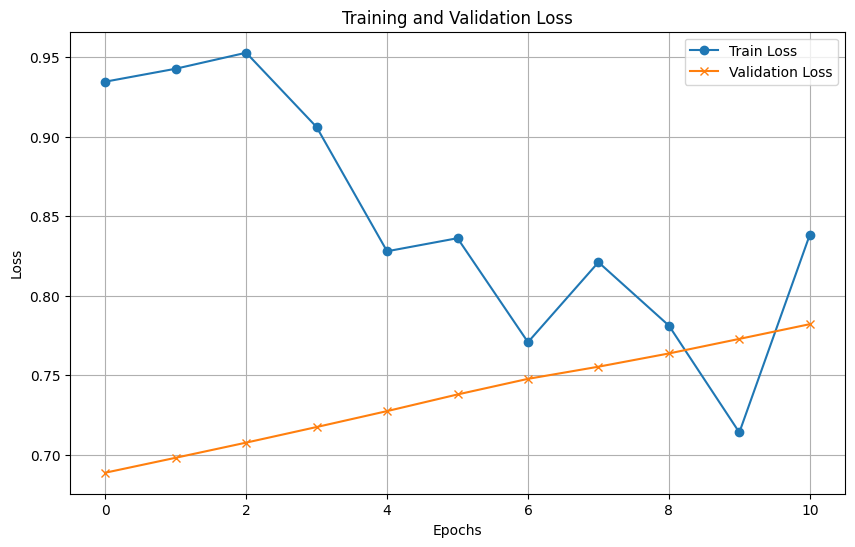

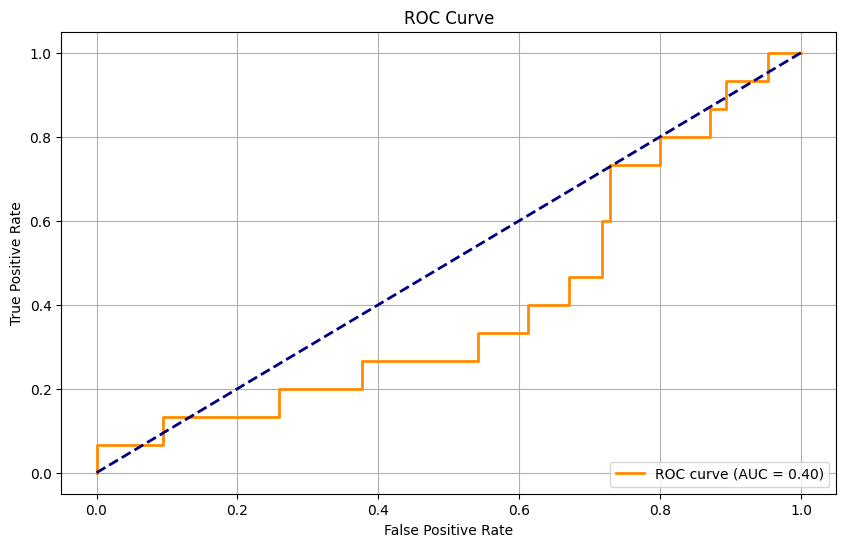

acc: 0.3600
bacc: 0.3765
macro_f1: 0.3209
weighted_f1: 0.4350
auroc: 0.4024
conf_matrix: [[30 55]
 [ 9  6]]
Running Fold 2 with model ann...
Train Shape: torch.Size([200, 512]), Validation Shape: torch.Size([111, 512]), Test Shape: torch.Size([94, 512])
Epoch 0 | Train Loss: 0.8430 | Val Loss: 0.5941
Epoch 10 | Train Loss: 0.6893 | Val Loss: 0.5816
Early stopping at epoch 16


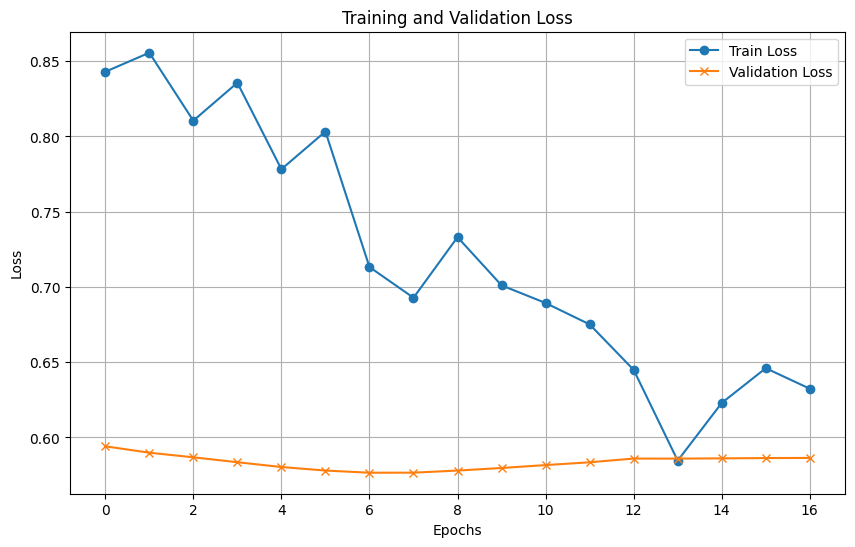

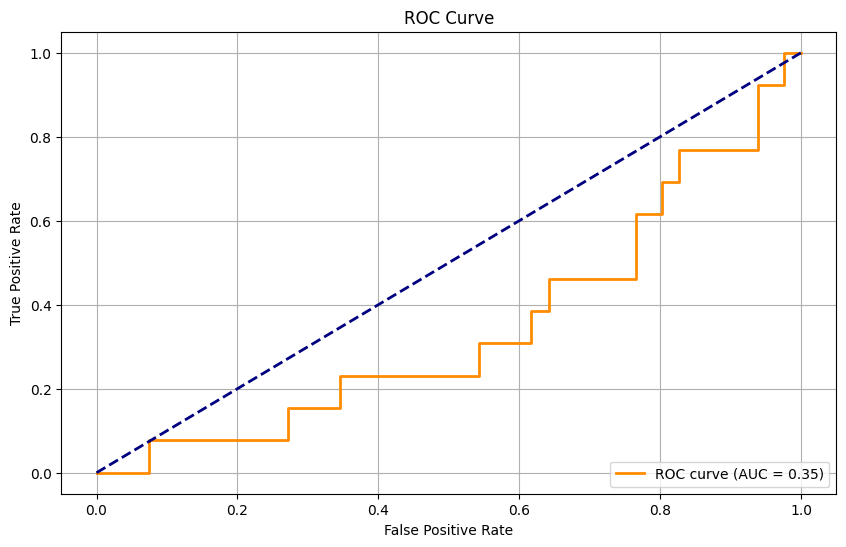

acc: 0.5957
bacc: 0.4425
macro_f1: 0.4362
weighted_f1: 0.6532
auroc: 0.3457
conf_matrix: [[53 28]
 [10  3]]
Running Fold 3 with model ann...
Train Shape: torch.Size([194, 512]), Validation Shape: torch.Size([100, 512]), Test Shape: torch.Size([111, 512])
Epoch 0 | Train Loss: 1.0272 | Val Loss: 0.6140
Early stopping at epoch 10


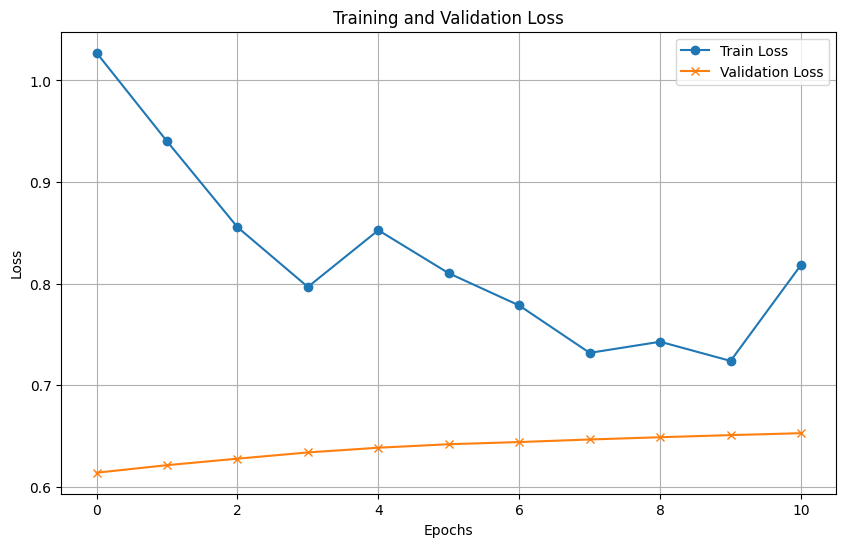

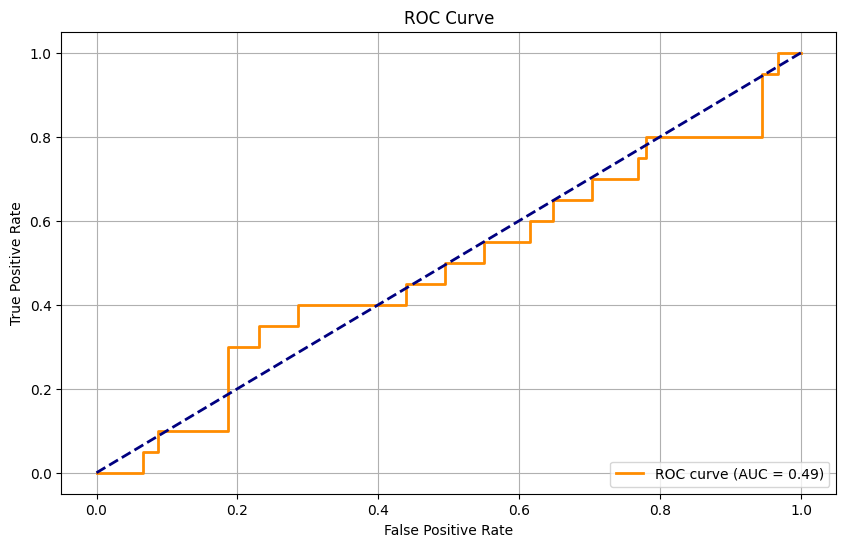

acc: 0.5405
bacc: 0.5052
macro_f1: 0.4638
weighted_f1: 0.5936
auroc: 0.4890
conf_matrix: [[51 40]
 [11  9]]
Running Fold 4 with model ann...
Train Shape: torch.Size([205, 512]), Validation Shape: torch.Size([100, 512]), Test Shape: torch.Size([100, 512])
Epoch 0 | Train Loss: 0.9338 | Val Loss: 0.7415
Early stopping at epoch 10


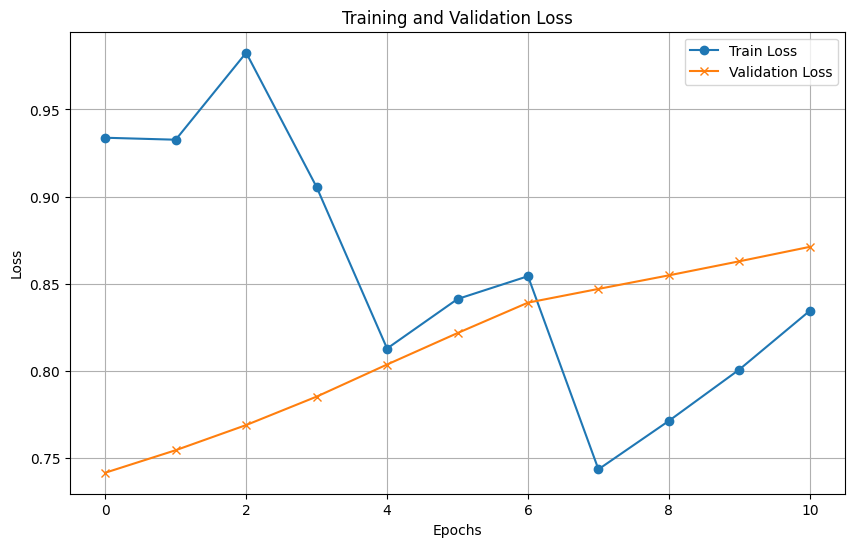

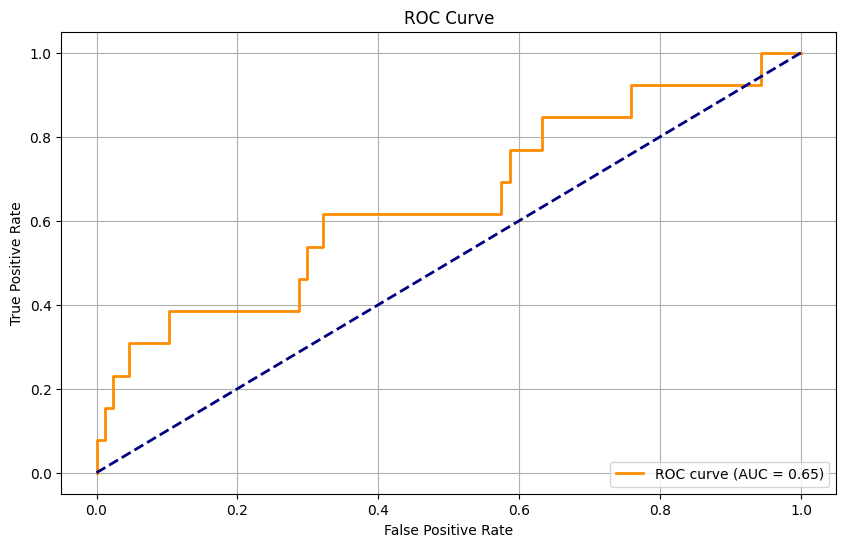

acc: 0.4500
bacc: 0.5531
macro_f1: 0.4068
weighted_f1: 0.5253
auroc: 0.6472
conf_matrix: [[36 51]
 [ 4  9]]


 Average results for all folds:
acc: 0.4866
bacc: 0.4693
macro_f1: 0.4069
weighted_f1: 0.5517
auroc: 0.4711


 ********* Training with model: knn********* 


Running Fold 1 with model knn...
knn_acc: 0.8500
knn_bacc: 0.5000
knn_macro_f1: 0.4595
knn_weighted_f1: 0.7811
knn_auroc: 0.6388
knn_conf_matrix: [[85  0]
 [15  0]]
Running Fold 2 with model knn...
knn_acc: 0.8617
knn_bacc: 0.5000
knn_macro_f1: 0.4629
knn_weighted_f1: 0.7977
knn_auroc: 0.4900
knn_conf_matrix: [[81  0]
 [13  0]]
Running Fold 3 with model knn...
knn_acc: 0.8018
knn_bacc: 0.4890
knn_macro_f1: 0.4450
knn_weighted_f1: 0.7296
knn_auroc: 0.4948
knn_conf_matrix: [[89  2]
 [20  0]]
Running Fold 4 with model knn...
knn_acc: 0.8600
knn_bacc: 0.4943
knn_macro_f1: 0.4624
knn_weighted_f1: 0.8045
knn_auroc: 0.6295
knn_conf_matrix: [[86  1]
 [13  0]]


 Average results for all folds:
acc: 0.8434
bacc: 0.4958
macro_f1: 0.4

In [36]:
# Example usage:
folds_df = pd.read_csv(K_FOLDS_PATH)
# Define your folds
fold1_ids = folds_df['Fold1'].dropna().apply(lambda x: x[:12]).tolist()
fold2_ids = folds_df['Fold2'].dropna().apply(lambda x: x[:12]).tolist()
fold3_ids = folds_df['Fold3'].dropna().apply(lambda x: x[:12]).tolist()
fold4_ids = folds_df['Fold4'].dropna().apply(lambda x: x[:12]).tolist()
folds = [fold1_ids, fold2_ids, fold3_ids, fold4_ids]

# Run k-fold cross-validation with different models
model_types = ['linear','ann','knn','protonet']
metric_indices = {
    'acc': 0,          # 'lin_acc' corresponds to index 0
    'bacc': 1,         # 'lin_bacc' corresponds to index 1
    'macro_f1': 2,        # 'lin_kappa' corresponds to index 2
    'weighted_f1': 3,  # 'lin_weighted_f1' corresponds to index 3
    'auroc': 4         # 'lin_auroc' corresponds to index 4
}

for model in model_types:
    print(f"\n\n ********* Training with model: {model}********* \n\n")
    k_folds_results = run_k_fold_cross_validation(DATA_PATH, folds, model_type=model)
    average_results = calculate_metric_averages_by_index(k_folds_results, metric_indices)
    print("\n\n Average results for all folds:")
    for metric, value in average_results.items():
        print(f"{metric}: {value:.4f}")